In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
import sys 
sys.path.insert(0, '../src/')

import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time
import galhalo
import mcmc_aux

import jsm_prephalo, jsm_stats
from scipy.stats import ks_2samp, chi2, combine_pvalues

In [12]:
# file = "../../data/3000_12_8/acc_surv_mass.npy"

# massmat = jsm_prephalo.MassMat(file, phimin=-4) #grab the data
# massmat.prep_data(includenan=False)

# np.save("../../data/MCMC/all_realizations.npy", massmat.lgMh)

creating the truth sample

In [4]:
prep = mcmc_aux.prep_chi2([1.85,0.3,0.5])
prep.SHMR()
prep.summary_stats()

showing how you go about picking the "real" data

In [5]:
#prep.measure_truth(mock_data_ind=17, plot=True)
# this is the data prep.model_lgMh

In [6]:
def MCMC_RUN(theta_0, lnprob, nwalkers=1000, niter=1000, ndim=3, ncores=8, converge=False):

    p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        start = time.time()
        sampler.run_mcmc(p0, niter)
        end = time.time()
        multi_time = end - start
        print("Run took {0:.1f} seconds".format(multi_time))

    if converge==True:
        tau = sampler.get_autocorr_time()
        print('$\\alpha$ took', tau[0], 'steps')
        print('$\\delta$ took', tau[1], 'steps')
        print('$\\sigma$ took', tau[2], 'steps')

    return sampler

starting the for loop

------------------------------------------------------------------------------------------------------------
SAGA ID: 0
------------------------------------------------------------------------------------------------------------
Run took 109.0 seconds


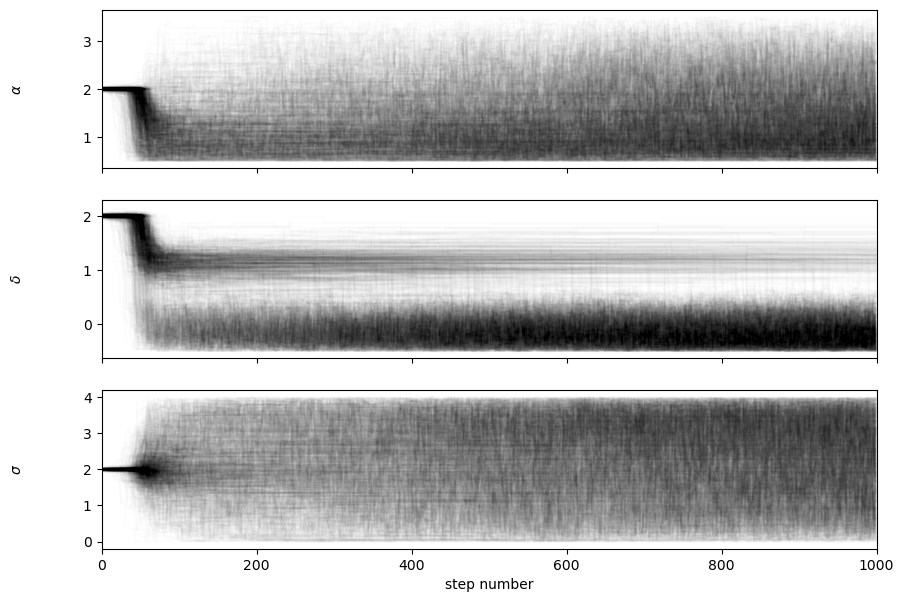

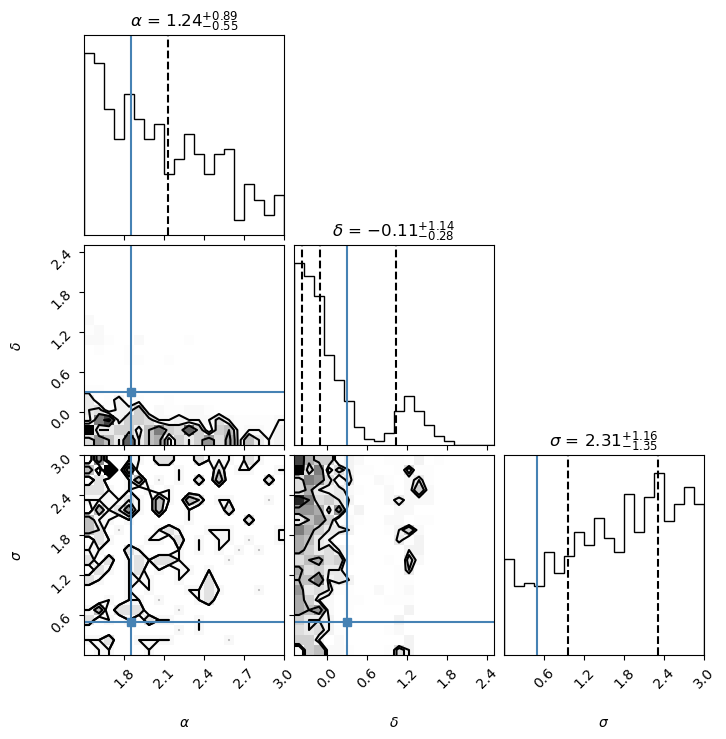

not normalizing for the upscatter


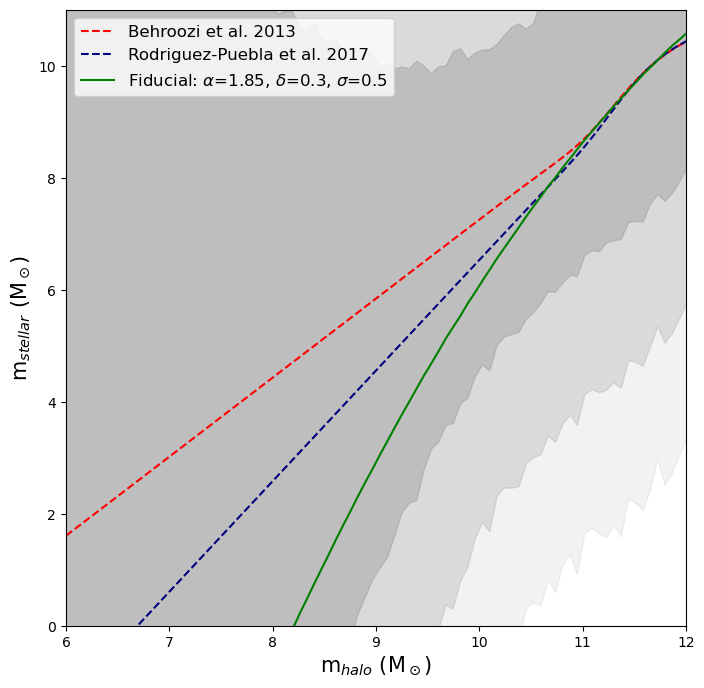

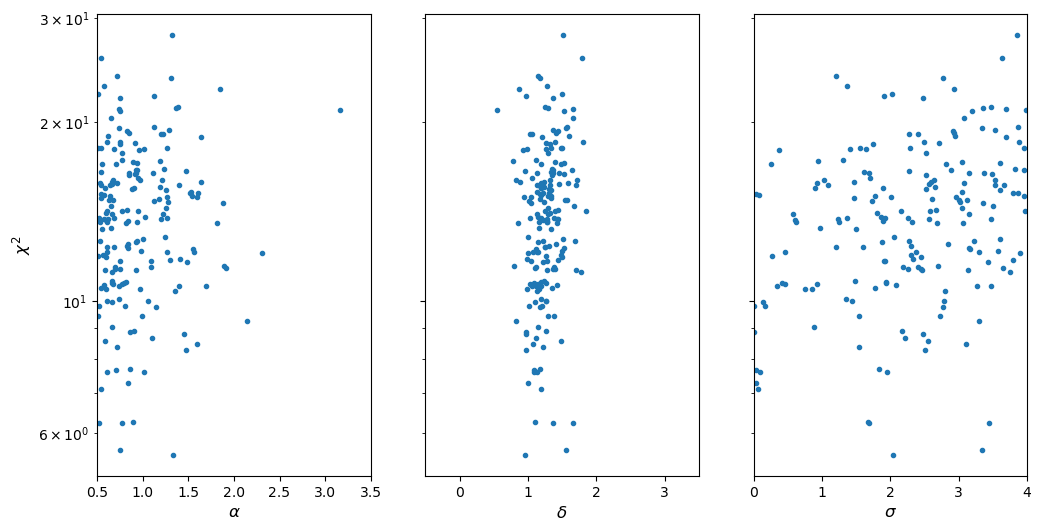

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
vals = []
for i in range(1):

    print("------------------------------------------------------------------------------------------------------------")
    print("SAGA ID:", i)
    print("------------------------------------------------------------------------------------------------------------")
    
    prep.measure_truth(mock_data_ind=i, plot=False)

    # each iteration needs to have a new version of these functions defined since the data doesnt include the SAGA sample being used
    def forward(theta):
        alpha, delta, sigma = theta #inputting the parameters
        lgMs = galhalo.SHMR(prep.model_lgMh, alpha, delta, sigma) # this is the mock obeservation
        satfreq = jsm_stats.satfreq(lgMs, 6.5) # for the single SAGA sample
        maxsatmass = jsm_stats.maxsatmass(lgMs)
        return satfreq, maxsatmass
    
    def lnlike(theta): # the log likelyhood function based on chi2
        satfreq, maxsatmass = forward(theta)
        chisquare_satfreq = np.nansum( ((satfreq - prep.data_PDF)/prep.error_PDF)**2 )
        chisquare_maxsatmass = np.nansum( ((maxsatmass - prep.data_CDF)/prep.error_CDF)**2 )  
        return -2*chisquare_satfreq #+ -2*chisquare_maxsatmass
    
    def lnprior(theta): # the priors
        alpha, delta, sigma = theta
        if 0.5 < alpha < 3.5 and -0.5 < delta < 3.5 and 0 < sigma < 4:
            return 0.0
        else:
            return -np.inf

    def lnprob(theta): # the log likelyhood fed into 
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        else:
            return lp + lnlike(theta)
        
    MCMC_i = MCMC_RUN([2,2,2], lnprob)
    run = mcmc_aux.inspect_run(MCMC_i, fid_theta=prep.fid_theta)

    run.chain_plot()
    run.corner_plot()
    run.SHMR_plot()
    run.chi_square_plot()
    val_i = run.best_fit_values()
    vals.append(val_i)